### Figure S3: Undercurrent 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34665/status,
Dashboard: /proxy/34665/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39187,Workers: 0
Dashboard: /proxy/34665/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33013,Total threads: 1
Dashboard: /proxy/43329/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:35193,


In [3]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

exp_ds = cat[experiment]
ext_ds = cat[exp_extension]

In [4]:
# Load model grid: 
walat = slice(-76,-63.99) # make sure t and u cells have same lengths
walon = slice(-140,-70)
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)

grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

hu = exp_ds.search(variable='hu').to_dask()['hu'].sel(yu_ocean=walat).sel(xu_ocean = walon).load()
ht = exp_ds.search(variable='ht').to_dask()['ht'].sel(yt_ocean=walat).sel(xt_ocean = walon).load()
area_t = exp_ds.search(variable='area_t').to_dask()['area_t'].sel(yt_ocean=walat).sel(xt_ocean = walon).fillna(0).load()
area_u = exp_ds.search(variable='area_u').to_dask()['area_u'].sel(yu_ocean=walat).sel(xu_ocean = walon).fillna(0).load()


In [5]:
# Load model output: 
start = '1984-01-01 00:00:00' # start date, 
end = '2019-01-01 00:00:00' # end date

# Load variables
t = exp_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end)) - 273.15
u = exp_ds.search(variable=['u'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['u'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
v=exp_ds.search(variable=['v'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['v'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))

# Load extension with intake:
start_ext = '2019-01-01 00:00:00' 
end_ext = '2024-01-01 00:00:00' # end date

# Load other 3D variables:
t_ext = ext_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext)) - 273.15
u_ext = ext_ds.search(variable=['u'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['u'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
v_ext = ext_ds.search(variable=['v'],frequency='1mon',variable_cell_methods='time: mean').to_dask()['v'].sel(yu_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))

In [6]:
# Concatenate and create annual
temp_full = xr.concat((t,t_ext),dim='time')
u_full = xr.concat((u,u_ext),dim='time')
v_full = xr.concat((v,v_ext),dim='time')
# Calculate annual
u_an = u_full.resample({'time':'Y'}).mean('time')
u_climatology = u_an.mean('time')
v_an = v_full.resample({'time':'Y'}).mean('time')
v_climatology = v_an.mean('time')
t_an = temp_full.resample({'time':'Y'}).mean('time')
t_climatology = t_an.mean('time')

In [7]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [8]:
# Calculate layer thickness on u cells
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': hu.yu_ocean, 'xu_ocean': hu.xu_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean': 'st_ocean'}))
thickness_u = thickness_u.fillna(0)

In [9]:
# Load HVE and WMP
# Load WMP on gamma:
wmp_gamma = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_wmp_gamma_on_stocean.nc')['WMP']
hve_gamma = temp_full-temp_full.mean('time')-wmp_gamma

wmp_gamma_an = wmp_gamma.resample({'time':'Y'}).mean()
hve_gamma_an = t_an-t_an.mean('time')-wmp_gamma_an

hve_14 = hve_gamma_an.sel(st_ocean = slice(100,400)).weighted(thickness).mean('st_ocean')
wmp_14 = wmp_gamma_an.sel(st_ocean = slice(100,400)).weighted(thickness).mean('st_ocean')

In [10]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

In [11]:
# Plot parametres: define projection and boundary path, landmask

xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen for HVE-WMP
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibm = make_boundary_path(lons, lats)
extent_pibm = [minlon,maxlon,minlat,maxlat]
projection_pibm = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


In [12]:
# Perform necessary calculaations: 
# Load 300-600m averages:
u_36 = u_an.sel(st_ocean = slice(300,600)).weighted(thickness_u).mean('st_ocean')
v_36 = v_an.sel(st_ocean = slice(300,600)).weighted(thickness_u).mean('st_ocean')

# Set mask for coastal box
pibs_mask = xr.where((ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).xt_ocean<-103.5) & (ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).yt_ocean>-74.5),np.nan,1)

# Calculate time series
#ts_pibsa = (t_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
#hve_pibsa = (hve_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
wmp_pibsa = (wmp_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
wmp_pib_ten = wmp_pibsa.differentiate('time',datetime_unit='s').load()

In [13]:
uc_an = (100*u_an).sel(xu_ocean = -116,method='nearest').sel(st_ocean = slice(300,600)).sel(yu_ocean = slice(-71.5,-71.3)).weighted((thickness_u*area_u).sel(xu_ocean = -116,method='nearest')).mean({'st_ocean','yu_ocean'})

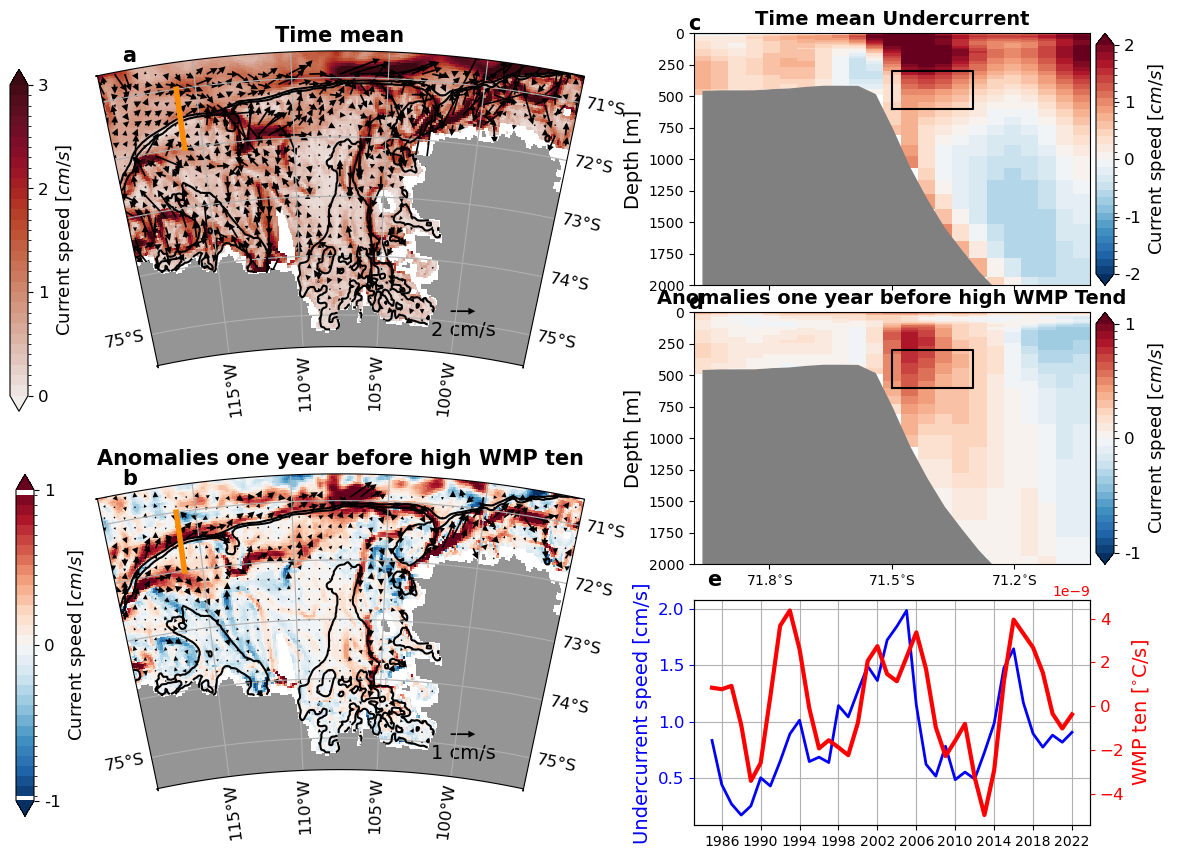

In [18]:
# Undercurrent
fig = plt.figure(figsize=(12,9))
for i in range(2):
    ax1 = plt.axes([0.085,0.54-0.47*i,0.41,0.38],projection = projection_pibm)
    ax1.set_extent(extent_pibm, crs=ccrs.PlateCarree())
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.left_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
    gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
    gl.xlabel_style = {'size': 12, 'color': 'k'}
    gl.ylabel_style = {'size': 12, 'color': 'k'}
    ax1.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())   
    if i==0:
        p1 = (100*np.sqrt(u_36**2+v_36**2)).mean('time').plot(ax=ax1,
                    x='xu_ocean', y='yu_ocean', levels = np.linspace(0,3,31), cmap=cm.cm.amp, add_colorbar = False, extend='both',
                    transform=ccrs.PlateCarree())
        p4 = ax1.quiver(u_an.xu_ocean,u_an.yu_ocean,u_36.mean('time').values,v_36.mean('time').values, color = 'k',regrid_shape=30, scale=0.4, width=0.0035, headwidth=4, headlength=4, headaxislength=4,transform = ccrs.PlateCarree())
        ax1.quiverkey(p4, X=.75, Y =0.2, U=0.02,
             label='2 cm/s', labelpos='S', fontproperties=({'size':14}))

        axin1 = plt.axes([0.015,0.52,0.015,0.38])
        cb=plt.colorbar(p1,cax=axin1,ticks=np.arange(0,4,1),orientation='vertical',aspect = 50)
        cb.set_label('Current speed [$cm/s$]',fontsize=13)
        #cb.tick_params('y', labelsize=14)
        cb.set_ticks(np.arange(0,4,1), labels=np.round(np.arange(0,4,1),0),fontsize=12)
    elif i==1:
        p1 = (100*(np.sqrt(u_36**2+v_36**2)-(np.sqrt(u_36**2+v_36**2)).mean('time'))).where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').plot(ax=ax1,
                    x='xu_ocean', y='yu_ocean', levels = np.linspace(-.5,.5,31), cmap='RdBu_r', add_colorbar = False, extend='both',
                    transform=ccrs.PlateCarree())
        axin1 = plt.axes([0.02,0.07,0.015,0.38])
        cb=plt.colorbar(p1,cax=axin1,ticks=np.arange(-1,2,1),orientation='vertical',aspect = 50)
        cb.set_label('Current speed [$cm/s$]',fontsize=13)
        #cb.tick_params('y', labelsize=14)
        cb.set_ticks(np.arange(-1,2,1), labels=np.round(np.arange(-1,2,1),0),fontsize=12)
        p4 = ax1.quiver(u_an.xu_ocean,u_an.yu_ocean,(u_36-u_36.mean('time')).where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').values,(v_36-v_36.mean('time')).where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').values, color = 'k',regrid_shape=30, scale=0.2, width=0.0035, headwidth=4, headlength=4, headaxislength=4,transform = ccrs.PlateCarree())
        ax1.quiverkey(p4, X=.75, Y =0.2, U=0.01,
             label='1 cm/s', labelpos='S', fontproperties=({'size':14}))

    land100.plot(ax=ax1,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
    p3 = ht.plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
    ax1.plot([-116,-116],[-72,-71],color='darkorange',linewidth=4,transform=ccrs.PlateCarree())
    if i==0:
        ax1.text(-107.5,-70.4,'Time mean', horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
        ax1.text(-118.5,-70.4,'a',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
    elif i==1:
        ax1.text(-107.5,-70.4,'Anomalies one year before high WMP ten', horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())
        ax1.text(-118.5,-70.4,'b',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())



ax2 = plt.axes([0.585,0.66,0.33,0.28])
p1 = (100*u_an).sel(xu_ocean = -116,method='nearest').sel(yu_ocean = slice(-72,-71)).mean('time').plot(ax=ax2,x='yu_ocean',levels=np.linspace(-2,2,31),add_colorbar=False,extend='both')
ax2.plot([-71.5,-71.3,-71.3,-71.5,-71.5],[600,600,300,300,600],color='k')
ax2.fill_between(u_an.yu_ocean.sel(yu_ocean = slice(-72,-71)),2500,hu.sel(xu_ocean = -116,method='nearest').sel(yu_ocean = slice(-72,-71)),color='grey')
ax2.set_ylim([2000,0])
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.set_title('Time mean Undercurrent', fontweight='bold', fontsize=14)
ax2.set_xlabel('')
ax2.text(-72,-30,'c',fontweight='bold',fontsize=15)
ax2.set_xticks(ticks=[-71.8,-71.5,-71.2],labels=['','',''])
# velocity colorbar
axin3 = plt.axes([0.92,0.66,0.015,0.28])
cb=plt.colorbar(p1,cax=axin3,ticks=np.arange(-5,7,2),orientation='vertical',aspect = 50)
cb.set_label('Current speed [$cm/s$]',fontsize=13)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(-2,3,1), labels=np.round(np.arange(-2,3,1),2),fontsize=12)


ax3 = plt.axes([0.585,0.35,0.33,0.28])
p1 = (100*(u_an-u_an.mean('time'))).sel(xu_ocean = -116,method='nearest').sel(yu_ocean = slice(-72,-71)).where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').plot(ax=ax3,x='yu_ocean',levels=np.linspace(-1,1,31),add_colorbar=False,extend='both')
ax3.plot([-71.5,-71.3,-71.3,-71.5,-71.5],[600,600,300,300,600],color='k')
ax3.fill_between(u_an.yu_ocean.sel(yu_ocean = slice(-72,-71)),2500,hu.sel(xu_ocean = -116,method='nearest').sel(yu_ocean = slice(-72,-71)),color='grey')
ax3.set_ylim([2000,0])
ax3.set_ylabel('Depth [m]',fontsize=14)
ax3.set_title('Anomalies one year before high WMP Tend', fontweight='bold', fontsize=14)
ax3.set_xlabel('')
ax3.text(-72,-30,'d',fontweight='bold',fontsize=15)
ax3.set_xticks(ticks=[-71.8,-71.5,-71.2],labels=['71.8$^{\circ}$S','71.5$^{\circ}$S','71.2$^{\circ}$S'])
# velocity colorbar
axin4 = plt.axes([0.92,0.35,0.015,0.28])
cb=plt.colorbar(p1,cax=axin4,ticks=np.arange(-2,3,1),orientation='vertical',aspect = 50)
cb.set_label('Current speed [$cm/s$]',fontsize=13)
#cb.tick_params('y', labelsize=14)
cb.set_ticks(np.arange(-1,2,1), labels=np.round(np.arange(-1,2,1),0),fontsize=12)


ax4 = plt.axes([0.585,0.06,0.33,0.25])
axb = ax4.twinx()
wmp_pib_ten.assign_coords(time = temp_full.time[6::12]).rolling(time=3,center=True).mean().plot(ax=axb,color='r',lw=3)
uc_an.chunk(time=-1).assign_coords(time = temp_full.time[6::12]).rolling(time=3,center=True).mean().plot(ax=ax4,color='b',lw=2)

ax4.grid()
ax4.set_ylabel('Undercurrent speed [cm/s]', fontsize=14,color='b')
axb.set_ylabel('WMP ten [$^{\circ}$C/s]',fontsize=14,color='r')
ax4.set_title('')
ax4.set_xlabel('')
ax4.tick_params('y', colors='b', labelsize=12)
axb.tick_params('y', colors='r', labelsize=12)
ax4.text(wmp_pibsa.time[0],2.2,'e',fontweight='bold',fontsize=15)
ax4.set_xticks(ticks=temp_full.time[30::48])

#plt.savefig('/home/581/or6852/plots/figures/supplement_undercurrent_v2.png')